In [1]:
%run Common.ipynb

In [2]:
import pandas as pd

np.set_printoptions(suppress=True,floatmode='maxprec_equal')

<h3>Looking at the data</h3>

In [3]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
ratings_df[0:10]

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
5       1     1263     2.0  1260759151
6       1     1287     2.0  1260759187
7       1     1293     2.0  1260759148
8       1     1339     3.5  1260759125
9       1     1343     2.0  1260759131

In [4]:
print("Unique ratings: %s" %str(np.unique(ratings_df['rating']).round(1)))

Unique ratings: [0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0]


In [5]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
print("Movies Shape: %s" %str(movies_df.shape))
movies_df[0:10]

Movies Shape: (9125, 3)


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller  
6                               Comedy|Romance  
7                           Adventure|Children  
8                                       Action  
9                    Action|Adventure|Thriller

<h1>Question 1: Calculating Sparsity</h1>

$$Sparsity = \frac{Total\ number\ of\ available\ ratings}{Total\ number\ of\ possible\ ratings}$$

<ul>
    <li>Total number of available ratings is the number of rows in the <b>ratings</b> table.</li>
    <li>Total number of possible ratings is $number\ of\ users\ times\ number\ of\ movies$.
</ul>

In [6]:
available_ratings_count = ratings_df.shape[0]
print("Number of available ratings: %d" %available_ratings_count)

Number of available ratings: 100004


In [7]:
unique_userids = np.unique(ratings_df[['userId']])
user_count = unique_userids.shape[0]
print("Number of users: %d" %user_count)

Number of users: 671


In [8]:
movie_count = movies_df.shape[0]
print("Number of movies: %d" %movie_count)

Number of movies: 9125


In [9]:
possible_ratings_count = user_count * movie_count
print("Number of possible ratings: %d" %possible_ratings_count)

Number of possible ratings: 6122875


In [10]:
sparsity = available_ratings_count / possible_ratings_count
print("Sparsity: %.5f" %sparsity)

Sparsity: 0.01633


<h3>Sparsity = 0.01633 (including movies with no ratings)</h3>

<h3>Number of movies with no ratings</h3>

In [11]:
movies_no_rating = set(movies_df['movieId']) - set(ratings_df['movieId'])
print("Number of movies with no ratings: %d" %len(movies_no_rating))

Number of movies with no ratings: 59


In [12]:
movies_df.loc[movies_df.movieId.isin(movies_no_rating)][0:10]

movieId                                              title  \
3693     4712        Wild Child, The (Enfant sauvage, L') (1970)   
3732     4763               Iron Ladies, The (Satree lek) (2000)   
3983     5169                              Scarlet Street (1945)   
4047     5289                               Body and Soul (1947)   
4414     5984              Story of O, The (Histoire d'O) (1975)   
4523     6229                           Two-Lane Blacktop (1971)   
4677     6515                          You Only Live Once (1937)   
4756     6683                                        Fire (1996)   
4836     6830                                 Sudden Fear (1952)   
5073     7243  Intolerance: Love's Struggle Throughout the Ag...   

                         genres  
3693                      Drama  
3732                     Comedy  
3983                  Film-Noir  
4047            Drama|Film-Noir  
4414              Drama|Romance  
4523                      Drama  
4677            Crime|Film-Noir  
4756                      Drama  
4836  Film-Noir|Horror|Thriller  
5073                      Drama

<h1>Question 2: Histogram</h1>

In [13]:
ratings_count_df = pd.DataFrame(ratings_df.groupby('rating').userId.agg('count'))
ratings_count_df.columns = ['count']
ratings_count_df.sort_index(inplace=True)
ratings_count_df

count
rating       
0.5      1101
1.0      3326
1.5      1687
2.0      7271
2.5      4449
3.0     20064
3.5     10538
4.0     28750
4.5      7723
5.0     15095

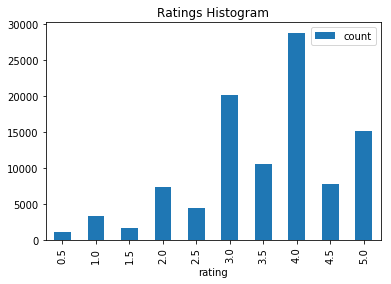

In [14]:
_ = ratings_count_df.plot.bar(title="Ratings Histogram")

<h3>Briefly comment on the shape of the histogram</h3>
<p>It is somewhat normally-distributed.</p>
<p>Users are less likely to give half point (0.5,1.5,2.5,etc.) ratings than full point ratings. Separating out the half point ratings from the full point ratings give two separate gaussian distributions.</p>

In [15]:
half_point_ratings_count = ratings_count_df.loc[ratings_count_df.index - ratings_count_df.index.astype(int) == 0.5]
full_point_ratings_count = ratings_count_df.loc[ratings_count_df.index - ratings_count_df.index.astype(int) == 0.0]

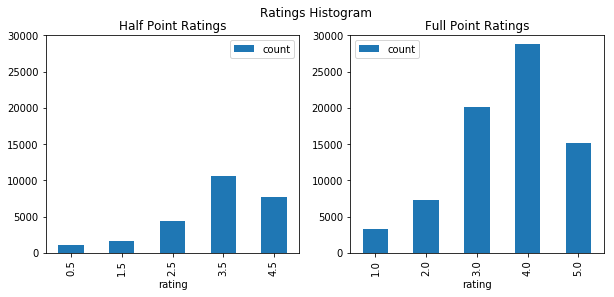

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
#fig.set_figheight(5)
fig.suptitle('Ratings Histogram')
half_point_ratings_count.plot.bar(ax=axes[0], ylim=(0.0,30000), title="Half Point Ratings")
_ = full_point_ratings_count.plot.bar(ax=axes[1], ylim=(0.0,30000), title="Full Point Ratings")

<h1>Question 3: Distribution of Ratings by Movies</h1>

In [17]:
movieratings_count_df = pd.DataFrame(ratings_df.groupby('movieId').rating.agg('count'))
movieratings_count_df.columns = ['count']
movieratings_count_df.sort_values('count', inplace=True, ascending=False)
movieratings_count_df.reset_index(inplace=True)
movieratings_count_df['movieId'] = movieratings_count_df['movieId'].apply(str)
movieratings_count_df[0:10]

movieId  count
0     356    341
1     296    324
2     318    311
3     593    304
4     260    291
5     480    274
6    2571    259
7       1    247
8     527    244
9     589    237

In [18]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
ax = movieratings_count_df.plot(ax=ax, x='movieId', y='count', title="Number of Ratings by Movie Ids",xticks=[0,500,1000,2000,4000,6000,9065])
ax.set_xlabel("Movie Ids (Sorted by Popularity)")
ax.set_ylabel("Number of Ratings")

Text(0,0.5,'Number of Ratings')

<h1>Question 4: Distribution of Ratings by Users</h1>

In [19]:
userratings_count_df = pd.DataFrame(ratings_df.groupby('userId').rating.agg('count'))
userratings_count_df.columns = ['count']
userratings_count_df.sort_values('count', inplace=True, ascending=False)
userratings_count_df.reset_index(inplace=True)
userratings_count_df['userId'] = userratings_count_df['userId'].apply(str)
userratings_count_df[0:10]

userId  count
0    547   2391
1    564   1868
2    624   1735
3     15   1700
4     73   1610
5    452   1340
6    468   1291
7    380   1063
8    311   1019
9     30   1011

Text(0,0.5,'Number of Ratings')

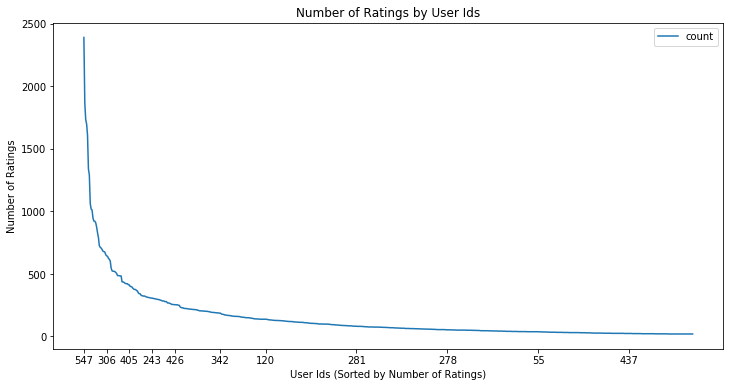

In [20]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
ax = userratings_count_df.plot(ax=ax, x='userId', y='count', title="Number of Ratings by User Ids",xticks=[0,25,50,75,100,150,200,300,400,500,600])
ax.set_xlabel("User Ids (Sorted by Number of Ratings)")
ax.set_ylabel("Number of Ratings")

<h1>Question 5</h1>
<h2>Explain the salient features of the distribution found in question 3 and their implications for the recommendation process</h2>

<p>A disproportionately small number of movies receive most of the ratings. Most movies have only a few ratings.</p>
<p>Similarly, a small percentage of users contribute most of the ratings.</p>
<p>As such, the distributions has long tails.</p>
<p>Since the most popular movies are likely to have already been seen by users, the recommender system should recommend less popular movies.</p>

<h1>Question 6: Movie Variances</h1>

<h3>Aggregate variance by movie id</h3>

In [21]:
movie_vars_df = pd.DataFrame(ratings_df.groupby('movieId').rating.agg('var'))
movie_vars_df.columns = ['variance']
movie_vars_df.dropna(inplace=True)
movie_vars_df[0:10]

variance
movieId          
1        0.919646
2        0.775657
3        1.322764
4        0.881410
5        0.899675
6        0.690441
7        1.216437
8        2.700000
9        0.660526
10       0.592603

<h3>Calculate bins</h3>

In [22]:
max_bin = int(movie_vars_df.variance.max().round())
bins = np.linspace(0.0, max_bin, max_bin * 2 + 1)
bins

array([ 0.0,  0.5,  1.0,  1.5,  2.0,  2.5,  3.0,  3.5,  4.0,  4.5,  5.0,
        5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0])

<h3>Plot with DataFrame.hist</h3>

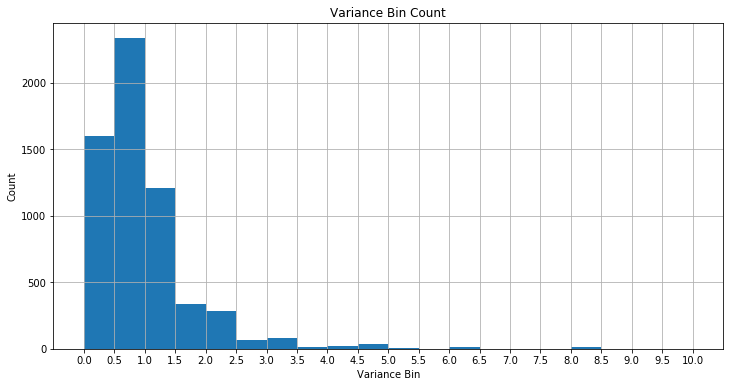

In [23]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
_ = movie_vars_df.hist(ax=ax, bins=bins)
ax.set_title('Variance Bin Count')
ax.set_xticks(bins)
ax.set_xlabel('Variance Bin')
_ = ax.set_ylabel('Count')

<h3>Alternative plot</h3>

In [24]:
movie_vars_df2 = movie_vars_df.assign(var_bin=movie_vars_df.variance.apply(lambda x: bins[np.digitize(x, bins, right=False)-1]))
movie_vars_df2[0:10]

variance  var_bin
movieId                   
1        0.919646      0.5
2        0.775657      0.5
3        1.322764      1.0
4        0.881410      0.5
5        0.899675      0.5
6        0.690441      0.5
7        1.216437      1.0
8        2.700000      2.5
9        0.660526      0.5
10       0.592603      0.5

In [25]:
movie_vars_count_df = pd.DataFrame(movie_vars_df2.groupby('var_bin').variance.agg('count'))
movie_vars_count_df.columns = ['count']
movie_vars_count_df

count
var_bin       
0.0       1598
0.5       2333
1.0       1206
1.5        335
2.0        281
2.5         63
3.0         80
3.5         17
4.0         21
4.5         36
5.0          4
6.0         15
8.0         11
10.0         3

Text(0,0.5,'Count')

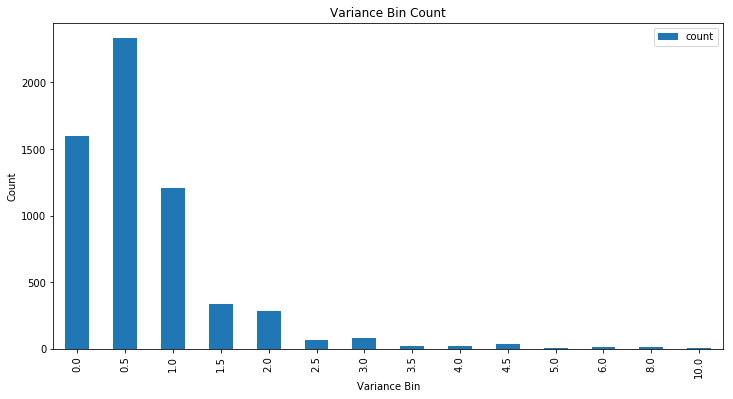

In [26]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
_ = movie_vars_count_df.plot.bar(ax=ax, title="Variance Bin Count")
ax.set_xlabel('Variance Bin')
ax.set_ylabel('Count')

<h3>Briefly comment on the shape of the histogram</h3>

<p>Variances of most movies are small. This means most users agree with each other on most of the movies and that there aren't many controversial movies.</p>